<a href="https://colab.research.google.com/github/Harshit0722/Neural-Network-Nexus-Team-Qubits/blob/main/NNN_Team_Qubits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import sklearn 
from tqdm import tqdm

from gensim.parsing.preprocessing import remove_stopwords
from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from collections import OrderedDict
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import classification_report,f1_score, average_precision_score, recall_score, precision_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras 
from keras import backend as K
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

import torch
!pip install transformers

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## File read and format conversion

In [ ]:
train = pd.read_csv('/content/Leads-data.csv', on_bad_lines = 'skip')
from pathlib import Path
import os
outdir = Path('.')
os.makedirs(str(outdir), exist_ok=True)
train.to_feather(outdir / 'train.feather')

In [ ]:
train = pd.read_feather('/content/train.feather')

## Data cleaning and pre-processing

In [ ]:
print(train.isna().sum())
print(train['status'].unique())

Unnamed: 0            0
Agent_id              0
status                0
lost_reason        3364
budget             3700
duration           2341
source                0
source_city           0
source_country        0
utm_source            0
utm_medium            0
des_city              0
des_country           0
room_type         23547
lead_id               0
dtype: int64
['LOST' 'WON' 'OPPORTUNITY' 'CONTACTED' 'PROCESSING' 'IMPORTANT']


In [ ]:
#Dropping NaN values(except for room_type):-

train = train.dropna(subset=['budget', 'duration'])
train = pd.DataFrame(train, columns=['status', 'budget', 'duration', 'room_type'])
train.reset_index(drop = 'true')

,status,budget,duration,room_type
0,LOST,£121 - £180 Per Week,Full Year Course Stay 40 - 44 weeks,Ensuite
1,LOST,0-0,0,None
2,LOST,120,semester-stay,None
3,LOST,0-0,0,None
4,LOST,£181 - £240 Per Week,51,Entire Place
...,...,...,...,...
42832,LOST,£60 - £120 Per week,Complete Education Year Stay 50 - 52 weeks,Studio
42833,LOST,£60 - £120 Per week,Summer/Short Stay 8 - 12 weeks,Studio
42834,LOST,£241 - £300 Per week,Full Year Course Stay 40 - 44 weeks,Studio
42835,LOST,1108,294,None


In [ ]:
#Converting to lowercase:-

train['budget'] = train['budget'].str.lower()
train['duration'] = train['duration'].str.lower()
train['room_type'] = train['room_type'].str.lower()

In [ ]:
#Dropping rows with deal status != {WON, LOST}

train.drop(train[(train['status'] =='OPPORTUNITY')].index, inplace=True)
train.drop(train[(train['status'] =='CONTACTED')].index, inplace=True)
train.drop(train[(train['status'] =='PROCESSING')].index, inplace=True)
train.drop(train[(train['status'] =='IMPORTANT')].index, inplace=True)

In [ ]:
#Replacing WON as 1, LOST as 0

train = train.replace("LOST", 0)
train = train.replace("WON", 1)

In [ ]:
#Concatenating for using input features 

train['detail'] = train['budget'] + train['duration'] + train['room_type']
train.head()

,status,budget,duration,room_type,detail
2,0,£121 - £180 per week,full year course stay 40 - 44 weeks,ensuite,£121 - £180 per weekfull year course stay 40 -...
3,0,0-0,0,None,NaN
5,0,120,semester-stay,None,NaN
6,0,0-0,0,None,NaN
7,0,£181 - £240 per week,51,entire place,£181 - £240 per week51entire place


In [ ]:
train.isna().sum()

status           0
budget           0
duration         0
room_type    19727
detail       19727
dtype: int64

In [ ]:
#Removing room_type NaN, since such values found out to be redundant

train = train.dropna(subset=['room_type'])
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22825 entries, 2 to 46607
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   status     22825 non-null  int64 
 1   budget     22825 non-null  object
 2   duration   22825 non-null  object
 3   room_type  22825 non-null  object
 4   detail     22825 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.0+ MB


In [ ]:
#Analyzing class imbalance:-
 
train['status'].value_counts()

0    21364
1     1461
Name: status, dtype: int64

## LSTM Model

In [ ]:
#Initialisation

import gensim
y = train['status'].values
X = [d.split() for d in train['detail'].tolist()]

In [ ]:
DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=DIM, window=10, min_count=1)
words = list(w2v_model.wv.index_to_key)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

In [ ]:
nos = np.array([len(x) for x in X])
len(nos[nos>13])

0

In [ ]:
maxlen = 13
X = pad_sequences(X, maxlen=maxlen)
len(X[0])

13

In [ ]:
vocab_size = len(tokenizer.word_index)+1
vocab = tokenizer.word_index

In [ ]:
def get_weight_matrix(model):
  weight_matrix = np.zeros((vocab_size, DIM))
  for word, i in vocab.items():
    weight_matrix[i] = model.wv[word]

  return weight_matrix 

In [ ]:
embedding_vectors = get_weight_matrix(w2v_model)
embedding_vectors.shape

(638, 100)

In [ ]:
#Model Construction:-

model = Sequential()
model.add(Embedding(vocab_size, output_dim=DIM, weights = [embedding_vectors], input_length = maxlen, trainable = False))
model.add(LSTM(units = 128))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 13, 100)           63800     
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 181,177
Trainable params: 117,377
Non-trainable params: 63,800
_________________________________________________________________


In [ ]:
#Splitting to obtain train and test data

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=42)

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [ ]:
model.fit(X_res, y_res, validation_split=0.3, epochs=2)

Epoch 1/2
701/701 [==============================] - 41s 55ms/step - loss: 0.5727 - acc: 0.7238 - val_loss: 1.1905 - val_acc: 0.0769
Epoch 2/2
701/701 [==============================] - 29s 41ms/step - loss: 0.5565 - acc: 0.7346 - val_loss: 1.2379 - val_acc: 0.1156


In [ ]:
y_pred = (model.predict(X_test) >=0.5).astype(int)

179/179 [==============================] - 4s 17ms/step


In [ ]:
accuracy_score(y_test, y_pred)

0.9278079551428071

In [ ]:
f1_score(y_test, y_pred)

0.07623318385650224

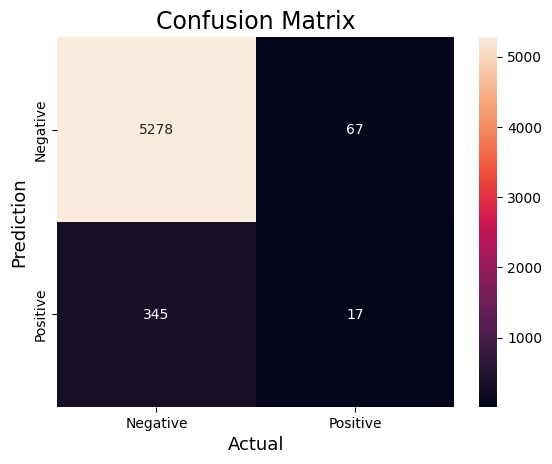

In [ ]:
from sklearn.metrics import confusion_matrix

#compute the confusion matrix.
cm = confusion_matrix(y_test,y_pred)
 
#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Negative','Positive'],
            yticklabels=['Negative','Positive'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

## SMOTE-TOMEK LINKS + Random Forest Classifier

In [ ]:
# import pandas as pd
# import numpy as np
# from imblearn.pipeline import Pipeline
# import matplotlib.pyplot as plt
# from sklearn.datasets import make_classification
# from sklearn.model_selection import cross_validate
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.ensemble import RandomForestClassifier
# from imblearn.combine import SMOTETomek
# from imblearn.under_sampling import TomekLinks

In [ ]:
# train_dummies=pd.get_dummies(train)
# train_dummies.head()
# #Churn dataset study case
# Y_churn=train_dummies['status'].values
# X_churn=train_dummies.drop('status',axis=1)

In [ ]:
# ## With SMOTE-Tomek Links method
# # Define model
# model2=RandomForestClassifier(criterion='entropy')
# # Define SMOTE-Tomek Links
# resample2=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
# # Define pipeline
# pipeline2=Pipeline(steps=[('r', resample2), ('m', model2)])
# # Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
# cv2=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# # Evaluate model
# scoring=['accuracy','precision_macro','recall_macro']
# scores2 = cross_validate(pipeline2, X_churn, Y_churn, scoring=scoring, cv=cv2, n_jobs=-1)
# # summarize performance
# print('Mean Accuracy: %.4f' % np.mean(scores2['test_accuracy']))
# print('Mean Precision: %.4f' % np.mean(scores2['test_precision_macro']))
# print('Mean Recall: %.4f' % np.mean(scores2['test_recall_macro']))